In [54]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
from PIL import Image
import matplotlib.patches as mpatches
import colorsys
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from sklearn.cluster import MeanShift, estimate_bandwidth

# tgtroot = '/media/senseable-beast/beast-brain-1/Data/streetviewdata/img/'
tgtroot = 'C:/Users/lezhi/Dropbox/thesis/img/'
dataroot = 'C:/Users/lezhi/Dropbox/thesis/data/'

In [2]:
cat_labels = ["Sky", "Building", "Pole", "Unlabelled", "Road", \
        "Pavement", "Tree", "SignSymbol", "Fence", \
        "Car", "Pedestrian", "Bicyclist"]

# def getmask(a, **kwargs):
#     inds = [labels.index(c)+243 for c in kwargs['category']]    
#     return [(ele in inds) for ele in np.nditer(a)]

# much better performance than the commented method...:
'''input a 2D index matrix, return a 2D boolean matrix 
where True means the pixel belongs to one of the specified "category".'''

def getmask(a, **kwargs):    
    inds = [cat_labels.index(c)+243 for c in kwargs['category']] 
    # print np.array(inds)-243
    indicators = np.zeros((a.shape[0], a.shape[1], len(inds))).astype(np.uint8)
    for i in range(len(inds)):
        indicators[:,:,i] = np.array(np.squeeze([a==inds[i]]))
    return np.any(indicators, axis=2)

# distinct and major color in ALL images (in 4-groups)

In [73]:
df = pd.DataFrame()

def iter_dir_4(rootdir, dostuff):
    
    citynames = np.array(sorted([d for d in os.listdir(rootdir) if os.path.isdir(rootdir)]))
    for cityname in citynames[np.array([1,3,7,9])]:   ######################
        print cityname
        citypath = rootdir + cityname
        imgnames = sorted([f[:-4] for f in os.listdir(citypath) if os.path.isfile(os.path.join(citypath, f))])[:10]
        
        lat_lng_dir = np.array([name.replace('_',',').split(',')[:2] for name in imgnames])
        df1 = pd.DataFrame(lat_lng_dir, columns=['lat', 'lng']).astype(str)############################################
        #df1['city'] = cityname
        df1['imgnames'] = [cityname + "/" + i+".png" for i in imgnames]
        df1gb = df1.groupby(['lat','lng'])
        
        df = df1gb.agg({"imgnames": lambda x: tuple(x)}).reset_index()
    
        records = df['imgnames'].apply(dostuff)
        del df['imgnames']
#         print records.values        
        
        df2 = pd.DataFrame.from_records(list(records.values), columns = ['_r', '_g', '_b', 'color'])
#         print df2
    
        df = pd.concat([df, df2], axis=1)
        df.to_csv(dataroot + 'color4_' + cityname +'.csv')
        

In [74]:

iter_dir_4(tgtroot, cal_color_4)

boston
chicago
newyork
sanfrancisco


In [57]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html

# each row is a tuple of image names
def cal_color_4(row):
    imarr = np.zeros([360, 480*len(row), 4]).astype(np.uint8) 
    for i in range(len(row)):
        indi_imarr = np.array(Image.open(tgtroot+ row[i])) # 51.45386,-0.138461068985_
        imarr[:, i*480 : (i+1)*480, :] = indi_imarr

    alpha = imarr[:, :, 3]
    
    mask = getmask(imarr[:,:,3], category=["Building", "SignSymbol", "Pole"]) ##
    if np.sum(mask) < 17280: ###################
        return (np.nan, np.nan, np.nan, np.nan)
    else:
        base = (0*np.ones((360, 480*len(row), 3))).astype(np.uint8)
        base[mask] = (imarr[:,:,:3])[mask]
        color_array = (imarr[:,:,:3])[mask]
        
        def not_black(hsv):         
            return hsv[2] > 0.001
        majority_func = lambda s: s[2]
        ms_quantile = 0.12

        image = (base.astype(np.float64)) /255

        w, h, d = original_shape = tuple(image.shape)
        assert d == 3
        image_array = np.reshape(image, (w * h, d))
        image_array_sample = shuffle(image_array, random_state=0)[:1000]

        bandwidth = estimate_bandwidth(image_array_sample, quantile=ms_quantile)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(image_array_sample)
        labels = ms.predict(image_array)
        labels_unique = np.unique(labels)
        n_clusters = len(labels_unique)
        centers = ms.cluster_centers_

        centers_hsv = [colorsys.rgb_to_hsv(i[0],i[1],i[2]) for i in centers]

        # tuples of index, color, number of pixels with that color
        sum_info = [(i, centers_hsv[i], np.sum(labels == i)) for i in range(len(centers_hsv))]
        non_black = [i for i in sum_info if not_black(i[1])]
        fq_c = max(non_black , key=majority_func)  

        def rgb_to_hex(rgb):
            rgb_ = tuple(((np.array(rgb)*255).astype(np.uint8))) 
            return '#%02x%02x%02x' % rgb_

        out_rgb = fq_c[1]
        out_hex = rgb_to_hex(colorsys.hsv_to_rgb(out_rgb[0], out_rgb[1], out_rgb[2]))

        return (out_rgb[0], out_rgb[1], out_rgb[2], out_hex)

# distinct and major color in ALL images (NOT in 4-groups)

In [70]:
def iter_dir(rootdir, dostuff):
    emptyfiles = [] 
    
    citynames = np.array(sorted([d for d in os.listdir(rootdir) if os.path.isdir(rootdir)]))
    for cityname in citynames[np.array([1,3,7,9])]:   ######################
        print cityname
        citypath = rootdir + cityname
        imgnames = sorted([f[:-4] for f in os.listdir(citypath) if os.path.isfile(os.path.join(citypath, f))])
        
        lat_lng_dir = np.array([name.replace('_',',').split(',') for name in imgnames])
        df1 = pd.DataFrame(lat_lng_dir, columns=['lat', 'lng', 'dir']).astype(str)############################################
        df1['city'] = cityname
        
        records = []
    
        for i in range(len(imgnames)): 
            img_filepath = citypath + "/" + imgnames[i] + ".png"
            if os.stat(img_filepath).st_size > 0:                
                image = Image.open(img_filepath) 
                records = records + [dostuff(image)]
            else:
                emptyfiles.append(cityname + "/" + imgnames[i] + ".txt")
        #print records        
        
        df2 = pd.DataFrame(records, columns = ["D1", 'D2', 'M'])
                           #columns=['D1h','D1s','D1v', 'D2h','D2s','D2v', 'Mh','Ms','Mv', "D1hex", 'D2hex', 'Mhex'])
        df = pd.concat([df1, df2], axis=1)
        df.to_csv(rootdir+cityname+'_color4'+'.csv')
        
    np.savetxt('encode_empty_files'+'.txt', emptyfiles, fmt="%s")
    print str(len(emptyfiles)) + " files are empty"

In [36]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html
def cal_color(im):
    imarr = np.array(im)
    alpha = imarr[:, :, 3]
    #plt.imshow(alpha)
    
    mask = getmask(imarr[:,:,3], category=["Building", "SignSymbol", "Pole"]) ##
    if np.sum(mask) < 17280: ###################
        return (np.nan, np.nan, np.nan)
    else:
        base = (0*np.ones((360,480,3))).astype(np.uint8)
        base[mask] = (imarr[:,:,:3])[mask]
        color_array = (imarr[:,:,:3])[mask]
        #plt.imshow(base)

        #n_colors = 9  ###############################
        def not_black(hsv):          ##
            return hsv[2] > 0.001
        majority_func = lambda s: s[2]#*s[1][1] ###################
        distinct_func = lambda s: s[1][1]#+s[1][2]   #########################
        ms_quantile = 0.1 ################################################

        image = (base.astype(np.float64)) /255

        # transform to a 2D numpy array.
        w, h, d = original_shape = tuple(image.shape)
        assert d == 3
        image_array = np.reshape(image, (w * h, d))
        image_array_sample = shuffle(image_array, random_state=0)[:1000]

        ############### predicting color using kmeans
        # kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
        # labels = kmeans.predict(image_array)
        # print "kmeans.cluster_centers_:", kmeans.cluster_centers_
        # centers = kmeans.cluster_centers_

        # ##################### Compute clustering with MeanShift
        # The following bandwidth can be automatically detected using
        bandwidth = estimate_bandwidth(image_array_sample, quantile=ms_quantile)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(image_array_sample)
        labels = ms.predict(image_array)
        # print "ms.cluster_centers_:", ms.cluster_centers_
        labels_unique = np.unique(labels)
        n_clusters = len(labels_unique)
        # print 'n_clusters:', n_clusters
        centers = ms.cluster_centers_

        centers_hsv = [colorsys.rgb_to_hsv(i[0],i[1],i[2]) for i in centers]

        # tuples of index, color, number of pixels with that color
        sum_info = [(i, centers_hsv[i], np.sum(labels == i)) for i in range(len(centers_hsv))]
        # print 'sum_info', sum_info
        non_black = [i for i in sum_info if not_black(i[1])]
        fq_c = max(non_black , key=majority_func)
        #print "most frequent color:", fq_c

        dt_c = sorted(non_black , key=distinct_func, reverse=True)[:2]
        #print "most distinct color:", dt_c    

        def rgb_to_hex(rgb):
            rgb_ = tuple(((np.array(rgb)*255).astype(np.uint8))) 
            #print '#%02x%02x%02x' % rgb_
            return '#%02x%02x%02x' % rgb_

        out_hsv = [i[1] for i in dt_c] + [fq_c[1]]
        out_hex = [rgb_to_hex(colorsys.hsv_to_rgb(i[0], i[1], i[2])) for i in out_hsv]

        return tuple(out_hex)

In [37]:
iter_dir(tgtroot, cal_color)

0 files are empty


# major color from one point (4 images)

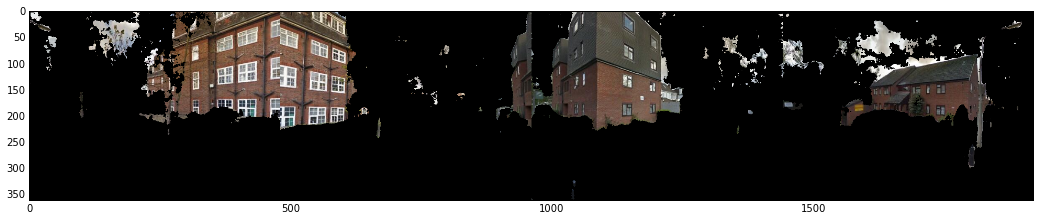

In [48]:
imarr = np.zeros([360,4*480,4]).astype(np.uint8) 
for i in range(4):
    indi_imarr = np.array(Image.open(tgtroot+'london/51.46136,-0.0926716179225_'+str(i)+'.png')) # 51.45386,-0.138461068985_
    imarr[:,i*480:(i+1)*480,:] = indi_imarr

alpha = imarr[:, :, 3]

mask = getmask(imarr[:,:,3], category=["Building", "SignSymbol", "Pole"])
base = (0*np.ones((360,480*4,3))).astype(np.uint8)
base[mask] = (imarr[:,:,:3])[mask]
color_array = (imarr[:,:,:3])[mask]
    
plt.figure(figsize=(18, 6))
plt.imshow(base) # plt.imshow(imarr)

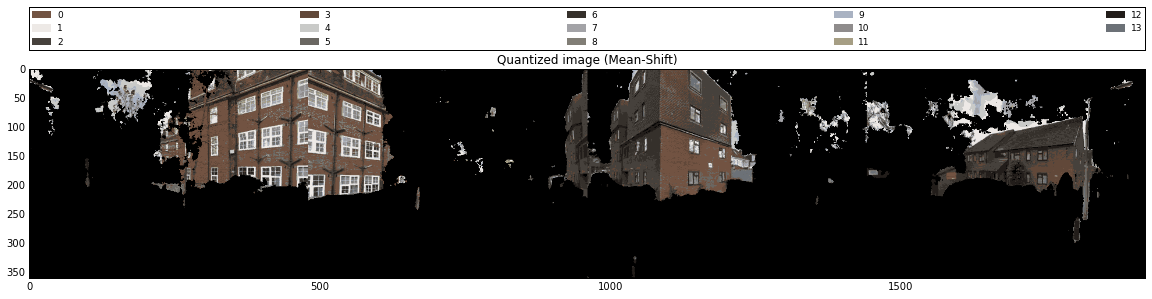

In [46]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html

def not_black(hsv):
    return hsv[2] > 0.001

majority_func = lambda s: s[2]*s[1][2]

ms_quantile = 0.12

image = Image.fromarray(base, 'RGB')
image = np.array(image, dtype=np.float64) / 255

# transform to a 2D numpy array.
w, h, d = original_shape = tuple(image.shape)
assert d == 3
image_array = np.reshape(image, (w * h, d))
image_array_sample = shuffle(image_array, random_state=0)[:1000]

bandwidth = estimate_bandwidth(image_array_sample, quantile=ms_quantile)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(image_array_sample)
labels = ms.predict(image_array)

#print "ms.cluster_centers_:", ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters = len(labels_unique)
#print 'n_clusters:', n_clusters
centers = ms.cluster_centers_

centers_hsv = [colorsys.rgb_to_hsv(i[0],i[1],i[2]) for i in centers]

# tuples of index, color, number of pixels with that color
sum_info = [(i, centers_hsv[i], np.sum(labels == i)) for i in range(len(centers_hsv))]
#print 'sum_info', sum_info
non_black = [i for i in sum_info if not_black(i[1])]
fq_c = sorted(non_black , key=majority_func, reverse=True)
#print "most frequent color:", fq_c

X_s = [i[1] for i in fq_c]

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image
#print "labels:", np.unique(labels)

# Display all results, alongside original image
plt.figure(figsize=(20, 15))

# plt.subplot(122)
plt.title('Quantized image (Mean-Shift)')
# new_cookbook = np.array([cluster_centers[i] for i in ms_labels])
new_cookbook = centers
plt.imshow(recreate_image(new_cookbook, labels, w, h))

lg_handles = []
lg_labels = []
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
def rgb_to_hex(rgb):
    rgb_ = tuple(((np.array(rgb)*255).astype(np.uint8))) 
    # print '#%02x%02x%02x' % rgb_
    return '#%02x%02x%02x' % rgb_

for i in range(len(X_s)):
    hexi = rgb_to_hex(tuple(colorsys.hsv_to_rgb(X_s[i][0], X_s[i][1], X_s[i][2])))
    rect = mpatches.Patch(color=hexi)
    lg_handles.append(rect)
    lg_labels.append(str(i))
plt.legend(lg_handles,lg_labels,bbox_to_anchor=(0. ,1.09 ,1.,0.3),loc=8,
           ncol=5,mode='expand',borderaxespad=0,prop={'size':9},numpoints=1)

# distinct and major color in one image

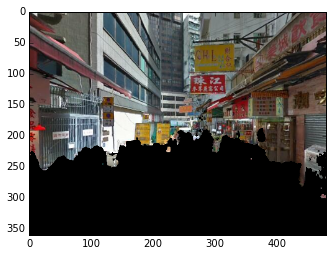

In [8]:
image = Image.open(tgtroot+'hongkong/22.278656,114.180662977_0.png') 
#  42.300131,-71.10339107_3  22.259156,114.200118326_1.png  22.266656,114.187148093_2.png  22.277156,114.170935302_1.png
# 22.278656,114.180662977_2  22.278656,114.166071465_0  22.278656,114.180662977_0  51.45386,-0.116771329008_1
# 51.45386,-0.138461068985_3  51.46136,-0.0926716179225_2 51.46286,-0.12882118455_3  40.701783,-73.9829296278_3

imarr = np.array(image)
alpha = imarr[:, :, 3]

mask = getmask(imarr[:,:,3], category=["Building", "SignSymbol", "Pole"])
base = (0*np.ones((360,480,3))).astype(np.uint8)
base[mask] = (imarr[:,:,:3])[mask]
color_array = (imarr[:,:,:3])[mask]
plt.imshow(base)

#6a6c67
#4b4946
#3d3833
#bdc5c4
#7a807e
#8a9191
#f6f7f4
#6f5d26
#d6dcdd
#942420
#a06857
#735a09
#b18c37
#ae9871
#dd9ba2
#b87a50


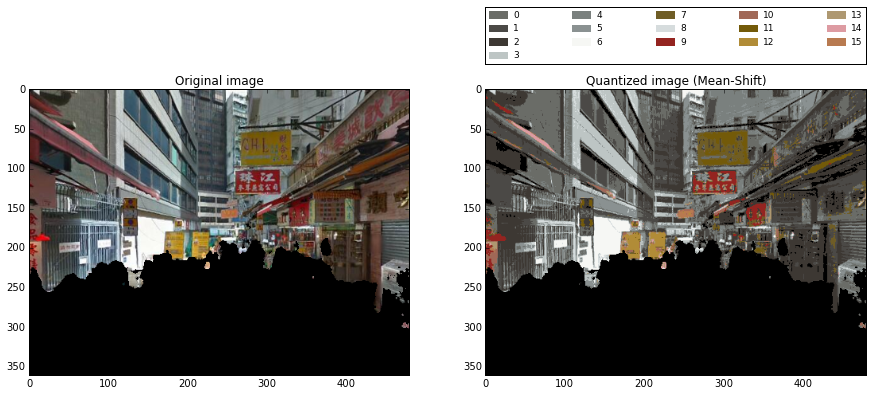

In [13]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html
n_colors = 9

def not_black(hsv):
    return hsv[2] > 0.001

majority_func = lambda s: s[2]*s[1][2]#*s[1][1]
distinct_func = lambda s: s[1][1]+s[1][2]

ms_quantile = 0.09

image = Image.fromarray(base, 'RGB')
image = np.array(image, dtype=np.float64) / 255

# transform to a 2D numpy array.
w, h, d = original_shape = tuple(image.shape)
assert d == 3
image_array = np.reshape(image, (w * h, d))
image_array_sample = shuffle(image_array, random_state=0)[:1000]

############### predicting color using kmeans
# kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
# labels = kmeans.predict(image_array)
# print "kmeans.cluster_centers_:", kmeans.cluster_centers_
# centers = kmeans.cluster_centers_

# ##################### Compute clustering with MeanShift
# The following bandwidth can be automatically detected using

ms_quantile = 0.09
bandwidth = estimate_bandwidth(image_array_sample, quantile=ms_quantile)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(image_array_sample)
labels = ms.predict(image_array)

#print "ms.cluster_centers_:", ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters = len(labels_unique)
#print 'n_clusters:', n_clusters
centers = ms.cluster_centers_

centers_hsv = [colorsys.rgb_to_hsv(i[0],i[1],i[2]) for i in centers]

# tuples of index, color, number of pixels with that color
sum_info = [(i, centers_hsv[i], np.sum(labels == i)) for i in range(len(centers_hsv))]
#print 'sum_info', sum_info
non_black = [i for i in sum_info if not_black(i[1])]
fq_c = sorted(non_black , key=majority_func, reverse=True)
#print "most frequent color:", fq_c

dt_c = sorted(non_black , key=distinct_func, reverse=True)[:2]
#print "most distinct color:", dt_c

#X_s = [i[1] for i in dt_c] + [fq_c[1]]
X_s = [i[1] for i in fq_c]

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

#print "labels:", np.unique(labels)

# Display all results, alongside original image
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.title('Original image')
plt.imshow(image)

plt.subplot(122)
plt.title('Quantized image (Mean-Shift)')
# new_cookbook = np.array([cluster_centers[i] for i in ms_labels])
new_cookbook = centers
plt.imshow(recreate_image(new_cookbook, labels, w, h))

lg_handles = []
lg_labels = []
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
def rgb_to_hex(rgb):
    rgb_ = tuple(((np.array(rgb)*255).astype(np.uint8))) 
    print '#%02x%02x%02x' % rgb_
    return '#%02x%02x%02x' % rgb_

for i in range(len(X_s)):
    hexi = rgb_to_hex(tuple(colorsys.hsv_to_rgb(X_s[i][0], X_s[i][1], X_s[i][2])))
    rect = mpatches.Patch(color=hexi)
    lg_handles.append(rect)
    lg_labels.append(str(i))
plt.legend(lg_handles,lg_labels,bbox_to_anchor=(0. ,1.09 ,1.,0.3),loc=8,
           ncol=5,mode='expand',borderaxespad=0,prop={'size':9},numpoints=1)